# Import libraries

In [6]:
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import numpy as np
import pandas as pd
from netrc import netrc
import os
from tqdm import tqdm
from pydap.cas.urs import setup_session
import shapely.geometry as sgeom
import cartopy.crs as ccrs
from dask.distributed import Client, LocalCluster, get_task_stream
import sys
from PIL import Image
from string import ascii_lowercase, ascii_uppercase


# Functions

In [2]:
def open_date_file(file_path):
    df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    df['BeginDate'] = df.BeginDate.apply(lambda t: pd.to_datetime(t, format='%Y-%m-%d'))
    return df

def store_wrappper(dataset_url):
    #time.sleep(5)
    session = setup_session(username, password, check_url=dataset_url)    
    store = xr.backends.PydapDataStore.open(dataset_url, session=session)
    return store

# Constants

In [3]:
xr.set_options(keep_attrs=True,display_style='html')


In [6]:
urs = 'urs.earthdata.nasa.gov'
netrcDir = os.path.expanduser("~/.netrc")
netrc_auth = netrc(netrcDir).authenticators(urs)
username = netrc_auth[0]
password = netrc_auth[2]
data_group = 'M2T1NXCHM.5.12.4' # M2I3NVASM.5.12.4
data_type = 'tavg1_2d_chm_Nx'#'inst3_3d_asm_Nv'
server_version = 4 # 5
basepath = f'https://goldsmr{server_version}.gesdisc.eosdis.nasa.gov/opendap/hyrax/MERRA2/{data_group}'
var_ls = 'TO3'

# Load data

In [4]:
name = 'himalayas'
df_dates = open_date_file(f"accelogw_{name}_hotspot@70hPa_20dayts_indexes.csv")
df_dates = df_dates[2:] # filter 1979
df_dates.head()

,BeginDate,oGWD
2,1981-02-21,-8.691035
3,1982-01-21,-6.814002
4,1982-02-20,-7.509872
5,1982-12-08,-6.954688
6,1983-02-14,-7.286437


In [25]:
lag = 3
store_ls = []
url_ls = []
for dt in tqdm(df_dates.BeginDate, total = df_dates.shape[0]):    # get recent year and month
    dt = dt + pd.Timedelta(f'{lag} days') # 3 days after strong OGWD event
    year = dt.year
    month = dt.month
    day = dt.day
    
    if year >= 1980 and year < 1992:
        file_number = '100'
    elif year >= 1992 and year < 2001:
        file_number = '200'
    elif year >= 2001 and year < 2011:
        file_number = '300'
    elif year >= 2011:
        file_number = '400'
    elif year == 2000 and  month == 9:
        file_number = '401'
    else:
        raise Exception('The specified year is out of range.')

    if month in [12,1,2]:
        infile = f'MERRA2_{file_number}.{data_type}.{year}{month:02d}{day:02d}.nc4'
        #print(infile)
        dataset_url = os.path.join(basepath, 
                               f'{year}',
                               f'{month:02d}',
                               infile)
        url_ls.append(dataset_url)
    #print(dataset_url)
    #store = xr.backends.PydapDataStore.open(dataset_url, session=session)
    #store_ls.append(store)
    #sys.exit()
    
#ds=xr.open_mfdataset(store_ls)[var_ls]
#ds

100%|██████████| 43/43 [00:00<00:00, 28380.03it/s]


In [6]:
len(url_ls)

35

In [39]:
results[0]

In [ ]:
https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXCHM.5.12.4/1981/02/MERRA2_100.tavg1_2d_chm_Nx.19810224.nc4.html

In [27]:
results = list(tqdm(map(store_wrappper, url_ls), total = len(url_ls)))

100%|██████████| 35/35 [03:58<00:00,  6.80s/it]


In [29]:
ds=xr.open_mfdataset(results)[var_ls]
ds

<xarray.DataArray 'TO3' (time: 840, lat: 361, lon: 576)>
dask.array<concatenate, shape=(840, 361, 576), dtype=float32, chunksize=(24, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 1981-02-24T00:30:00 ... 2010-02-16T23:30:00
Attributes:
    long_name:       total_column_ozone
    units:           Dobsons
    fmissing_value:  999999987000000.0
    standard_name:   total_column_ozone
    vmax:            999999987000000.0
    vmin:            -999999987000000.0
    valid_range:     [-999999987000000.0, 999999987000000.0]
    origname:        TO3
    fullnamepath:    /TO3

In [5]:
outfile = f'/mnt/data02/model/CMAM/0A.daily/{var_ls}_{name}_events_hourly.nc'
#ds.to_netcdf(outfile)

NameError: name 'var_ls' is not defined

# Visualization

## MERRA2

In [8]:
outfile = f'/mnt/data04/model/CMAM/0A.daily/{var_ls}_{name}_events_hourly.nc'
da = xr.open_dataarray(outfile)
da

<xarray.DataArray 'TO3' (time: 840, lat: 361, lon: 576)>
[174666240 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 1981-02-24T00:30:00 ... 2010-02-16T23:30:00
Attributes:
    long_name:       total_column_ozone
    units:           Dobsons
    fmissing_value:  999999987000000.0
    standard_name:   total_column_ozone
    vmax:            999999987000000.0
    vmin:            -999999987000000.0
    valid_range:     [-9.99999987e+14  9.99999987e+14]
    origname:        TO3
    fullnamepath:    /TO3

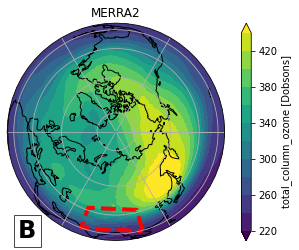

In [23]:
central_longitude = 90
projection = ccrs.Orthographic(central_longitude, 90)
ax = plt.axes(projection=projection)
p = da.mean('time').plot.contourf(transform=ccrs.PlateCarree(), \
           ax = ax, robust = True, extend = 'both',
                                  levels = 11) # robust = True, 
#p.colorbar.set_ticks(ticks)
ax = p.axes
ax.coastlines()
ax.gridlines()

box = sgeom.box(minx=70, maxx=105, miny=20, maxy=42)
ax.add_geometries([box], ccrs.PlateCarree(), \
                  facecolor=['none'], edgecolor=['red'], \
                  linestyle = ['dashed'],
                  linewidth = [4])
ax.set_title('MERRA2')
ax.text(0.05, 0.1, ascii_uppercase[1], transform=ax.transAxes,
                  fontsize=24, fontweight='bold', va='top', bbox={'alpha': 0.7, 'facecolor': 'white'})
plt.savefig(f'{var_ls}_MERRA2_{name}_composite_verif_fig.pdf', 
            #dpi = 300, 
            bbox_inches='tight')

In [10]:
vmax = p.colorbar.vmax # 430
vmin = p.colorbar.vmin # 238
ticks = p.colorbar.get_ticks() # [238., 258., 278., 298., 318., 338., 358., 378., 398., 418.]#
levels = p.levels

In [91]:
p.colorbar.get_ticks()

array([220., 260., 300., 340., 380., 420.])

In [11]:
cluster = LocalCluster(host='195.113.23.121')#, n_workers=4
client = Client(cluster) # 
client

/home/kuchar/.conda/envs/moje/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33921 instead
  warnings.warn(


Client Scheduler: tcp://195.113.23.121:41189 Dashboard: http://195.113.23.121:33921/status,Cluster Workers: 8 Cores: 64 Memory: 503.57 GiB


## CMAM

In [13]:
sel_var = 'toz'
root_path = '/mnt/data04/model/CMAM/0A.daily/'
infiles = f'{root_path}{sel_var}/{sel_var}_6hrChem_CMAM_CMAM30-SD_r1i1p1_*18.nc'
ds_cmam = xr.open_mfdataset(infiles, concat_dim = 'time', 
                       parallel = True, combine='nested',
                       data_vars='minimal', coords='minimal', compat='override')
ds_cmam

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 48, lon: 96, time: 46720)
Coordinates:
  * time       (time) object 1979-01-01 00:00:00 ... 2010-12-31 18:00:00
  * lat        (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon        (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(1460, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(48, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(96, 2), meta=np.ndarray>
    toz        (time, lat, lon) float32 dask.array<chunksize=(1460, 48, 96), meta=np.ndarray>
Attributes: (12/30)
    institution:            CCCma (Canadian Centre for Climate Modelling and ...
    institute_id:           CCCma
    experiment_id:          CMAM30-SD
    source:                 CMAM 2013
    model_id:               CMAM
    forcing:                N/A
    ...                     ...
    table_id:               Table 6hrChem (10 April 2013) 060cf2ef7544c9cc9bc...
    title:                  CMAM model output prepared for CMAM30 CMAM 30-yea...
    parent_experiment:      N/A
    modeling_realm:         atmosChem
    realization:            1
    cmor_version:           2.8.2

In [14]:
temp = ds_cmam['toz'].resample(time = '1D').mean().load()
temp['time'] = temp.indexes['time'].to_datetimeindex()
temp

/tmp/ipykernel_4016791/1994889851.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  temp['time'] = temp.indexes['time'].to_datetimeindex()


<xarray.DataArray 'toz' (time: 11680, lat: 48, lon: 96)>
array([[[308.28363, 307.89368, 307.53223, ..., 309.63864, 309.15466,
         308.70343],
        [317.13998, 316.76346, 316.2622 , ..., 317.77594, 317.61285,
         317.41296],
        [329.89343, 328.66467, 327.1104 , ..., 331.6684 , 331.3939 ,
         330.80106],
        ...,
        [336.3016 , 337.52637, 339.34396, ..., 335.90723, 335.6067 ,
         335.6916 ],
        [348.33356, 348.4414 , 348.7615 , ..., 349.3319 , 348.79688,
         348.45346],
        [337.69373, 337.41266, 337.1103 , ..., 338.37726, 338.1805 ,
         337.9511 ]],

       [[318.87073, 318.77518, 318.65057, ..., 318.9738 , 318.97034,
         318.93597],
        [318.21732, 317.15076, 316.1012 , ..., 321.28796, 320.31628,
         319.2812 ],
        [314.86926, 313.74426, 312.87515, ..., 321.1623 , 318.5463 ,
         316.43677],
...
        [309.51028, 308.08466, 306.52853, ..., 313.5514 , 312.21252,
         310.87076],
        [313.8608 , 311.6558 , 309.636  , ..., 320.79492, 318.49866,
         316.17383],
        [345.3057 , 345.4164 , 345.6409 , ..., 345.50214, 345.35803,
         345.29092]],

       [[319.7889 , 319.85443, 319.88922, ..., 319.39667, 319.56073,
         319.6913 ],
        [317.34277, 317.59042, 317.72427, ..., 316.12494, 316.58954,
         317.00183],
        [312.3133 , 313.81378, 315.0021 , ..., 307.20288, 308.89377,
         310.63086],
        ...,
        [327.35443, 325.9582 , 324.48166, ..., 329.6124 , 329.3363 ,
         328.5351 ],
        [326.78955, 326.74426, 326.6013 , ..., 326.37537, 326.59283,
         326.73135],
        [335.95465, 337.08978, 338.32   , ..., 333.19095, 333.9834 ,
         334.91348]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2010-12-31
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
Attributes:
    standard_name:     equivalent_thickness_at_stp_of_atmosphere_ozone_content
    long_name:         O3 Column
    units:             DU
    cell_methods:      time:mean
    cell_measures:     area: areacella
    history:           2013-05-28T08:50:04Z altered by CMOR: replaced missing...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

In [16]:
dates = df_dates.set_index('BeginDate')
lag = 3
dates = dates.index + pd.Timedelta(str(lag)+' days')
#filter lags withi 29th February
#dates = dates[dates.apply(lambda x: not (x.day in [29] and x.month in [2]))]
dates = dates[~((dates.month == 2) & (dates.day == 29))]
#filter dates shited to year out of range
#dates = dates[dates.apply(lambda x: not (x.year in [1978,2011]))]
dates =  dates[(dates.year != 2011) & (dates.year != 1978)]
dates = dates[(dates.month == 12) | (dates.month == 1) | (dates.month == 2)]

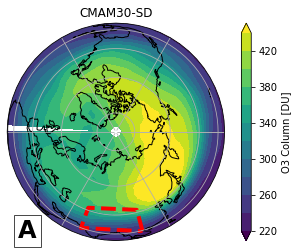

In [24]:
central_longitude = 90
projection = ccrs.Orthographic(central_longitude, 90)
ax = plt.axes(projection=projection)
arr = temp.sel(time = dates).mean('time').load()
p = arr.plot.contourf(transform=ccrs.PlateCarree(), \
           ax = ax, 
           vmax = vmax, vmin = vmin, extend = 'both',
           levels = levels,
           )
p.colorbar.set_ticks(ticks)
ax = p.axes
ax.coastlines()
ax.gridlines()

box = sgeom.box(minx=70, maxx=105, miny=20, maxy=42)
ax.add_geometries([box], ccrs.PlateCarree(), \
                  facecolor=['none'], edgecolor=['red'], \
                  linestyle = ['dashed'],
                  linewidth = [4])
ax.set_title('CMAM30-SD')
ax.text(0.05, 0.1, ascii_uppercase[0], transform=ax.transAxes,
                  fontsize=24, fontweight='bold', va='top', bbox={'alpha': 0.7, 'facecolor': 'white'})
plt.savefig(f'{var_ls}_CMAM30-SD_{name}_composite_verif_fig.pdf', 
#            dpi = 300, 
            bbox_inches='tight')

## ERA5

In [7]:
var_ls = 'TO3'
name = 'himalayas'

era_infile = f'/mnt/data04/model/CMAM/0A.daily/{var_ls}_ERA5_{name}_events_hourly.nc'
ds_era = xr.open_dataset(era_infile)
to_du = 2.1415e-5 # https://sacs.aeronomie.be/info/dobson.php
da_era = ds_era['tco3']/to_du 
da_era.attrs['units'] = 'DU'
da_era

<xarray.DataArray 'tco3' (time: 989, lat: 721, lon: 1440)>
array([[[246.2416 , 246.2416 , 246.2416 , ..., 246.2416 , 246.2416 ,
         246.2416 ],
        [247.32152, 247.32152, 247.32152, ..., 247.31595, 247.31595,
         247.31595],
        [248.76328, 248.76884, 248.76884, ..., 248.7577 , 248.7577 ,
         248.76328],
        ...,
        [402.4912 , 402.48566, 402.48007, ..., 402.50235, 402.49677,
         402.49677],
        [401.28882, 401.28882, 401.28326, ..., 401.29437, 401.29437,
         401.28882],
        [400.00848, 400.00848, 400.00848, ..., 400.00848, 400.00848,
         400.00848]],

       [[244.98318, 244.98318, 244.98318, ..., 244.98318, 244.98318,
         244.98318],
        [246.04085, 246.04085, 246.04085, ..., 246.03528, 246.03528,
         246.03528],
        [247.72754, 247.73311, 247.73868, ..., 247.7164 , 247.72197,
         247.72754],
...
        [485.08463, 485.0735 , 485.06235, ..., 485.11246, 485.10132,
         485.09018],
        [483.92676, 483.9212 , 483.91565, ..., 483.9379 , 483.93234,
         483.92676],
        [483.48145, 483.48145, 483.48145, ..., 483.48145, 483.48145,
         483.48145]],

       [[256.84567, 256.84567, 256.84567, ..., 256.84567, 256.84567,
         256.84567],
        [256.91248, 256.91248, 256.91248, ..., 256.91248, 256.91248,
         256.91248],
        [256.67868, 256.6731 , 256.6731 , ..., 256.67868, 256.67868,
         256.67868],
        ...,
        [483.79144, 483.78586, 483.7803 , ..., 483.80814, 483.80255,
         483.797  ],
        [483.32382, 483.32382, 483.31827, ..., 483.33496, 483.3294 ,
         483.3294 ],
        [483.08447, 483.08447, 483.08447, ..., 483.08447, 483.08447,
         483.08447]]], dtype=float32)
Coordinates:
    realization  int64 ...
  * time         (time) datetime64[ns] 1981-02-21T01:00:00 ... 2010-02-13T23:...
  * lat          (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon          (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
Attributes:
    units:    DU

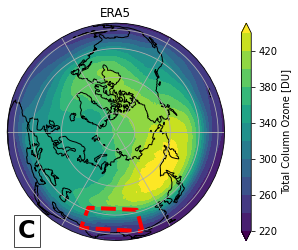

In [25]:
central_longitude = 90
projection = ccrs.Orthographic(central_longitude, 90)
ax = plt.axes(projection=projection)
p = da_era.mean('time').plot.contourf(transform=ccrs.PlateCarree(), \
           ax = ax, 
           vmax = vmax, vmin = vmin, extend = 'both',
           levels = levels,
           )
p.colorbar.set_ticks(ticks)
ax = p.axes
ax.coastlines()
ax.gridlines()

box = sgeom.box(minx=70, maxx=105, miny=20, maxy=42)
ax.add_geometries([box], ccrs.PlateCarree(), \
                  facecolor=['none'], edgecolor=['red'], \
                  linestyle = ['dashed'],
                  linewidth = [4])
ax.set_title('ERA5')
ax.text(0.05, 0.1, ascii_uppercase[2], transform=ax.transAxes,
                  fontsize=24, fontweight='bold', va='top', bbox={'alpha': 0.7, 'facecolor': 'white'})
plt.savefig(f'{var_ls}_ERA5_{name}_composite_verif_fig.pdf', 
#            dpi = 300, 
            bbox_inches='tight')

# MERGE

In [31]:
what_ls = ['CMAM30-SD','MERRA2','ERA5']
images = [Image.open(f'{var_ls}_{what}_{name}_composite_verif_fig.png') 
          for what in what_ls]
widths, heights = zip(*(i.size for i in images))

total_width = sum(widths)
max_height = max(heights)

new_im = Image.new('RGB', (total_width, max_height))

x_offset = 0
for im in images:
  new_im.paste(im, (x_offset,0))
  x_offset += im.size[0]

new_im.save('test.jpg')